In [ ]:
import tensorflow.data as data
from tensorflow import round
from tensorflow.python.keras.backend import sum, mean, log
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv3D, BatchNormalization, Activation, Input, MaxPooling3D, Conv3DTranspose, concatenate
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

import nibabel as nib
from sklearn.preprocessing import MinMaxScaler
from ipywidgets import interact
import numpy as np
import pandas as pd
import os
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
trainingPath = '/content/drive/MyDrive/imagesTr/'
labelTrPath = '/content/drive/MyDrive/labelsTr/'
trainingData = os.listdir(trainingPath)
labelTrData = os.listdir(labelTrPath)
trainingData.sort()
labelTrData.sort()

validationPath = '/content/drive/MyDrive/imagesVal/'
labelValPath = '/content/drive/MyDrive/labelsVal/'
validationData = os.listdir(validationPath)
labelValData = os.listdir(labelValPath)
validationData.sort()
labelValData.sort()

testingPath = '/content/drive/MyDrive/imagesTs/'
labelTsPath = '/content/drive/MyDrive/labelsTs/'
testingData = os.listdir(testingPath)
labelTsData = os.listdir(labelTsPath)
testingData.sort()
labelTsData.sort()

#merg every two lists into list of tuple
trainingData = [(trainingData[i], labelTrData[i]) for i in range(0,len(labelTrData))]
validationData = [(validationData[i], labelValData[i]) for i in range(0,len(labelValData))]
testingData = [(testingData[i], labelTsData[i]) for i in range(0,len(labelTsData))]


In [ ]:
#add the name of data to the path
def  joinPath(item, typeP='Tr'):
  if typeP == 'Tr':
    image = os.path.join(trainingPath,item[0])
    label = os.path.join(labelTrPath,item[1])
    return (image, label)
  if typeP == 'Va':
    image = os.path.join(validationPath,item[0])
    label = os.path.join(labelValPath,item[1])
    return (image, label)
  if typeP == 'Ts':
    image = os.path.join(testingPath,item[0])
    label = os.path.join(labelTsPath,item[1])
    return (image, label)


trainData = [joinPath(item, 'Tr') for item in trainingData]
valData = [joinPath(item, 'Va') for item in validationData]
testData = [joinPath(item, 'Ts') for item in testingData]
print(len(trainData), len(valData), len(testData))
print(trainData[0:10])

399 50 34
[('/content/drive/MyDrive/imagesTr/BRATS_001.nii.gz', '/content/drive/MyDrive/labelsTr/BRATS_001.nii.gz'), ('/content/drive/MyDrive/imagesTr/BRATS_002.nii.gz', '/content/drive/MyDrive/labelsTr/BRATS_002.nii.gz'), ('/content/drive/MyDrive/imagesTr/BRATS_003.nii.gz', '/content/drive/MyDrive/labelsTr/BRATS_003.nii.gz'), ('/content/drive/MyDrive/imagesTr/BRATS_004.nii.gz', '/content/drive/MyDrive/labelsTr/BRATS_004.nii.gz'), ('/content/drive/MyDrive/imagesTr/BRATS_006.nii.gz', '/content/drive/MyDrive/labelsTr/BRATS_006.nii.gz'), ('/content/drive/MyDrive/imagesTr/BRATS_008.nii.gz', '/content/drive/MyDrive/labelsTr/BRATS_008.nii.gz'), ('/content/drive/MyDrive/imagesTr/BRATS_009.nii.gz', '/content/drive/MyDrive/labelsTr/BRATS_009.nii.gz'), ('/content/drive/MyDrive/imagesTr/BRATS_010.nii.gz', '/content/drive/MyDrive/labelsTr/BRATS_010.nii.gz'), ('/content/drive/MyDrive/imagesTr/BRATS_012.nii.gz', '/content/drive/MyDrive/labelsTr/BRATS_012.nii.gz'), ('/content/drive/MyDrive/imagesTr/B

In [ ]:
#the parameters
numData = 399
numVal = 50
numTs = 34
classes = 4
batchSize = 2
seeds = 333
epochs = 10
volumSize = (128,128,128,3) 

In [ ]:
imageTest = np.array(nib.load(trainData[0][0]).get_fdata())
labelTest = np.array(nib.load(trainData[0][1]).get_fdata())
print(imageTest.shape, labelTest.shape)
print(np.unique(labelTest))

(240, 240, 155, 4) (240, 240, 155)
[0. 1. 2. 3.]


In [ ]:
#Visualize the image and the label in 3D
def show_layer_from_3d_image(layer):
  fig, axis = plt.subplots(ncols=2, figsize=(10,15))
  axis[0].set_title(f'the FLAIR of layer {layer}', fontsize=11)
  axis[0].imshow(imageTest[:,:,layer,3])
  axis[0].axis('off')

  axis[1].set_title(f'the layer {layer} of the label', fontsize=11)
  axis[1].imshow(labelTest[:,:,layer])
  axis[1].axis('off')
  return layer


interact(show_layer_from_3d_image, layer=(0,155))


interactive(children=(IntSlider(value=77, description='layer', max=155), Output()), _dom_classes=('widget-inte…

<function __main__.show_layer_from_3d_image>

# Preparing the data
- Throw the T1 channel
- get volum with size (128, 128, 128, 3)
- normlize the image by using MinMaxScaler
- standardize the image by making it's mean=0 and sd=1

In [ ]:
def throwT1(img):
  return np.stack([img[:,:,:,0], img[:,:,:,2], img[:,:,:,3]], axis=-1)
imageTest = throwT1(imageTest)
imageTest.shape

(240, 240, 155, 3)

In [ ]:
def getVolum(img, lbl):
  x = volumSize[0]
  y = volumSize[1]
  z = volumSize[2]
  return img[55:55+x, 55:55+y, 20:20+z, :], lbl[55:55+x, 55:55+y, 20:20+z]
imageTest, labelTest = getVolum(imageTest, labelTest)
print(imageTest.shape, labelTest.shape)
print(np.unique(labelTest))

(128, 128, 128, 3) (128, 128, 128)
[0. 1. 2. 3.]


In [ ]:
print(np.min(imageTest), np.max(imageTest))
def normlize(img):
  scaler = MinMaxScaler()
  return scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
imageTest = normlize(imageTest)
print(np.min(imageTest), np.max(imageTest))
print(imageTest.shape, labelTest.shape)

0.0 2239.0
0.0 1.0
(128, 128, 128, 3) (128, 128, 128)


In [ ]:
def standrize(img):
  temp = np.zeros(img.shape)
  #standardize the image
  for c in range(img.shape[-1]):
    imgChannel = img[:, :, :, c]
    for s in range(128):
      imgSlice = imgChannel[:, :, s]
      centeredImg = imgSlice -  np.mean(imgSlice)
      if np.std(centeredImg) != 0:
        centeredScaledImg = centeredImg/np.std(centeredImg)
        temp[:, :, s, c] = centeredScaledImg
      else:
        temp[:, :, s, c] = centeredImg
  return temp
  
tst = standrize(imageTest)
print(np.mean(tst), np.std(tst), tst.shape)

-1.6855729774907976e-16 0.9762812094883317 (128, 128, 128, 3)


In [ ]:
def read_data(idx, val=False):
  if val:
    image = np.array(nib.load(valData[idx][0]).get_fdata())
    label = np.array(nib.load(valData[idx][1]).get_fdata())

  else:
    image = np.array(nib.load(trainData[idx][0]).get_fdata())
    label = np.array(nib.load(trainData[idx][1]).get_fdata())
    
  #Throw T1 channel
  image = throwT1(image)
  #crop the image and label
  image, label = getVolum(image, label)
  #nromlize the image 
  image = normlize(image)
  #standrize the image
  image = standrize (image)
  #one-hot ecncoding for label
  label = to_categorical(label, num_classes=classes)
  return image, label

img, lbl = read_data(2)
img.shape, lbl.shape

((128, 128, 128, 3), (128, 128, 128, 4))

In [ ]:
def read_batch(st, en, val=False):
  images=[]
  labels=[]

  for i in range(st, en):
    img, lbl = read_data(i, val)
    images.append(img)
    labels.append(lbl)

  return np.array(images), np.array(labels)


def imageLoader(val=False):
  while True:
    batch_start = 0
    batch_end = batchSize
    if val:
      while batch_start < numVal:
        limit = min(batch_end, numVal)        
        X, Y = read_batch(batch_start, limit, val)

        yield (X,Y)

        batch_start += batchSize   
        batch_end += batchSize

    else:
      while batch_start < numData:
        limit = min(batch_end, numData)        
        X, Y = read_batch(batch_start, limit, val)

        yield (X,Y) 

        batch_start += batchSize   
        batch_end += batchSize

In [ ]:
train_img_datagen = imageLoader()
validat_img_datagen = imageLoader(val=True)

In [ ]:
img, lbl = train_img_datagen.__next__()
vim, vlb = validat_img_datagen.__next__()

In [ ]:
print(img.shape, lbl.shape)
print(vim.shape, vlb.shape)

(2, 128, 128, 128, 3) (2, 128, 128, 128, 4)
(2, 128, 128, 128, 3) (2, 128, 128, 128, 4)


# Metrics and Evaluations

In [ ]:
def diceCoef(y, y_pred, axis=(0,1,2), eps=1e-4):
  y_pred = round(y_pred)  # Round to 0 or 1
  numerator   = 2*sum(y*y_pred, axis=axis) + eps
  denominator = sum(y, axis=axis) + sum(y_pred, axis=axis) + eps
  coef = mean(numerator/denominator)

  return coef


def softDiceCoef(y, y_pred, axis=(0,1,2), eps=1e-4):
  numerator   = 2*sum(y*y_pred, axis=axis) + eps
  denominator = sum(y, axis=axis) + sum(y_pred, axis=axis) + eps
  coef = mean(numerator/denominator)

  return coef

In [ ]:
def diceLoss(y, y_pred, axis=(0,1,2), eps=1e-4):
  numerator   = mean((sum(y*y_pred, axis=axis)+eps))
  sumY = sum(y, axis=axis)
  sumP = sum(y_pred, axis=axis)
  denominator = mean((sumY+sumP+eps))
  loss = -log(2.0*numerator) + log(denominator)
  
  return loss

In [ ]:
#test the dice loss
pred = np.array([[[[1.0, 1.0], [0.0, 0.0]],
                  [[1.0, 0.0], [0.0, 1.0]]],
                 [[[1.0, 1.0], [0.0, 0.0]],
                  [[1.0, 0.0], [0.0, 1.0]]]
                  ])
label = np.array([[[[1.0, 0.0], [1.0, 0.0]],
                   [[1.0, 0.0], [0.0, 0.0]]],
                  [[[0.0, 0.0], [0.0, 0.0]],
                   [[1.0, 0.0], [0.0, 0.0]]]
                  ])

dc = diceLoss(pred, label)
print(f"dice loss",dc)    

dice loss tf.Tensor(0.6930971826431813, shape=(), dtype=float64)


In [ ]:
def sensitivityANDspecificity(y, y_pred, classNum):
  # extract sub-array for specified class
  labelPred = y_pred[:,:,:,classNum]
  label = y[:,:,:,classNum]
  # true positives
  tp = np.sum((labelPred == 1) & (label == 1))
  # true negatives
  tn = np.sum((labelPred == 0) & (label == 0))
  #false positives
  fp = np.sum((labelPred == 1) & (label == 0))
  # false negatives
  fn = np.sum((labelPred == 0) & (label == 1))
  # compute sensitivity and specificity
  sensitivity = tp / (tp + fn)
  specificity = tn / (tn + fp)

  return sensitivity, specificity

# Define the 3D-Unet network 

In [ ]:
def getBlock(x, filters, name):
  x = Conv3D(filters, (3,3,3), padding="same", kernel_initializer="he_uniform", name=name+"_conv0")(x)
  x = BatchNormalization(name=name+"_bn0")(x)
  x = Activation("relu", name=name+"_relu0")(x)

  x = Conv3D(filters, (3,3,3), padding="same", kernel_initializer="he_uniform", name=name+"_conv1")(x)
  x = BatchNormalization(name=name+"_bn1")(x)
  x = Activation("relu", name=name+"_relu1")(x)
  
  return x


def getModel(volumSize):
  #start the encoder
  input_layer = Input(shape=volumSize, name="Input_layer")
  
  #block1
  block1 = getBlock(input_layer, 16, "block1")
  maxPool1 = MaxPooling3D(name="maxPool1", pool_size=(2, 2, 2))(block1)

  #block2
  block2 = getBlock(maxPool1, 32, "block2")
  maxPool2 = MaxPooling3D(name="maxPool2", pool_size=(2, 2, 2))(block2)

  #block3
  block3 = getBlock(maxPool2, 64, "block3")
  maxPool3 = MaxPooling3D(name="maxPool3", pool_size=(2, 2, 2))(block3)  

  #block4
  block4 = getBlock(maxPool3, 128, "block4")
  maxPool4 = MaxPooling3D(name="maxPool4", pool_size=(2, 2, 2))(block4)

  #block5
  block5 = getBlock(maxPool4, 256, "block5")

  #end the encoder

  #start decoder
  transConve = Conv3DTranspose(name="transpose5", filters=128, kernel_size=(2, 2, 2), strides=(2, 2, 2), padding="same")(block5)
  concat4 = concatenate([transConve, block4], axis=-1, name="concat4")
  decode3 = getBlock(concat4, 128, "decode3")

  transConve = Conv3DTranspose(name="transpose3", filters=64, kernel_size=(2, 2, 2), strides=(2, 2, 2), padding="same")(decode3)
  concat3 = concatenate([transConve, block3], axis=-1, name="concat3")
  decode2 = getBlock(concat3, 64, "decode2")

  transConve = Conv3DTranspose(name="transconv2", filters=32, kernel_size=(2, 2, 2), strides=(2, 2, 2), padding="same")(decode2)
  concat2 = concatenate([transConve, block2], axis=-1, name="concat2")
  decode1 = getBlock(concat2, 32,  "decode1")

  transConve = Conv3DTranspose(name="transconv1", filters=16, kernel_size=(2, 2, 2), strides=(2, 2, 2), padding="same")(decode1)
  concat1 = concatenate([transConve, block1], axis=-1, name="concat1")
  outConve = getBlock(concat1, 16, "outConve")
  #end the decoder

  
  prediction = Conv3D(name="predictionLabel", filters=4, kernel_size=(1, 1, 1), activation="softmax")(outConve)
  model = Model(inputs=[input_layer], outputs=[prediction], name="Brain_tumor_segmentation")
  model.summary()

  return model

In [ ]:
model = getModel(volumSize)

Model: "Brain_tumor_segmentation"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_layer (InputLayer)        [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
block1_conv0 (Conv3D)           (None, 128, 128, 128 1312        Input_layer[0][0]                
__________________________________________________________________________________________________
block1_bn0 (BatchNormalization) (None, 128, 128, 128 64          block1_conv0[0][0]               
__________________________________________________________________________________________________
block1_relu0 (Activation)       (None, 128, 128, 128 0           block1_bn0[0][0]                 
___________________________________________________________________________

In [ ]:
 from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

filepath="/content/drive/MyDrive/saved_models/weights-improvement-{epoch:02d}-{val_softDiceCoef:.2f}.hdf5" 
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
log_csv = CSVLogger('/content/drive/MyDrive/my_logs6.csv', separator=',', append=False)

callbacks_list = [checkpoint, log_csv]

# Train the network

In [ ]:
#model.compile(loss=diceLoss, metrics=[diceCoef, softDiceCoef], optimizer="adam")
#history = model.fit(train_img_datagen, steps_per_epoch=len(trainData)//batchSize,
                  #  validation_data=validat_img_datagen, validation_steps=len(valData)//batchSize,
                   # epochs=epochs, verbose=2, callbacks=callbacks_list) 

In [ ]:
#from keras.models import load_model

#new_model = load_model('/content/drive/MyDrive/saved_models/weights-improvement-12-0.51.hdf5', custom_objects={'diceLoss':diceLoss, 'diceCoef':diceCoef, 'softDiceCoef':softDiceCoef}) 
#history = new_model.fit(train_img_datagen, steps_per_epoch=len(trainData)//batchSize,
#                    validation_data=validat_img_datagen, validation_steps=len(valData)//batchSize,
#                    epochs=epochs, verbose=2, callbacks=callbacks_list)


In [ ]:
from keras.models import load_model
my_model = load_model('/content/drive/MyDrive/saved_models/weights-improvement-12-0.51.hdf5', custom_objects={'diceLoss':diceLoss, 'diceCoef':diceCoef, 'softDiceCoef':softDiceCoef}) 

In [ ]:
def read_test(idx):
  image = np.array(nib.load(testData[idx][0]).get_fdata())
  label = np.array(nib.load(testData[idx][1]).get_fdata())
    
  #Throw T1 channel
  image = throwT1(image)
  #crop the image and label
  image, label = getVolum(image, label)
  #nromlize the image 
  image = normlize(image)
  #standrize the image
  image = standrize (image)
  #one-hot ecncoding for label
  label = to_categorical(label, num_classes=classes)
  return image, label

img, lbl = read_test(2)
img.shape, lbl.shape

((128, 128, 128, 3), (128, 128, 128, 4))

In [ ]:
def read_batch_test(st, en):
  images=[]
  labels=[]

  for i in range(st, en):
    img, lbl = read_test(i)
    images.append(img)
    labels.append(lbl)

  return np.array(images), np.array(labels)


def testLoader():
  while True:
    batch_start = 0
    batch_end = batchSize
    while batch_start < numTs:
      limit = min(batch_end, numTs)        
      X, Y = read_batch_test(batch_start, limit)

      yield (X,Y)

      batch_start += batchSize   
      batch_end += batchSize


In [ ]:
test_img_datagen = testLoader()

In [ ]:
my_model.evaluate(test_img_datagen, batch_size=2, steps=len(testData)//batchSize, )

17/17 [==============================] - 119s 5s/step - loss: 0.0137 - diceCoef: 0.8139 - softDiceCoef: 0.5107


[0.01367692369967699, 0.8139212727546692, 0.5106865167617798]

# Test the model with example


In [ ]:
index = 0
image, label4dim = read_test(index)
fullSizeImg = np.array(nib.load(testData[index][0]).get_fdata())
label = np.argmax(label4dim,axis=-1)
print(image.shape)
print(fullSizeImg.shape)
print(label.shape)
print(label4dim.shape)
print(np.unique(label))

(128, 128, 128, 3)
(240, 240, 155, 4)
(128, 128, 128)
(128, 128, 128, 4)
[0 1 2 3]


In [ ]:
imageIn = np.expand_dims(image, axis=0)
print(imageIn.shape)

(1, 128, 128, 128, 3)


In [ ]:
y_hat = my_model.predict(imageIn)
labelPred = round(y_hat)
sensBackground, specBackground = sensitivityANDspecificity(labelPred[0], label4dim, 0)
sensEdma, specEdma = sensitivityANDspecificity(labelPred[0], label4dim, 1)
sensNonEnh, specNonEnh = sensitivityANDspecificity(labelPred[0], label4dim, 2)
sensEnh, specEnh = sensitivityANDspecificity(labelPred[0], label4dim, 3)

print(f"the sensitivity of the Background class is {sensBackground}\nthe specificity of the background class is {specBackground}")
print("********************************************************")
print(f"the sensitivity of the Edma class is {sensEdma}\nthe specificity of the Edma class is {specEdma}")
print("********************************************************")
print(f"the sensitivity of the Non-enhancing class is {sensNonEnh}\nthe specificity of the Non-enhancing class is {specNonEnh}")
print("********************************************************")
print(f"the sensitivity of the Enhancing class is {sensEnh}\nthe specificity of the Enhancing class is {specEnh}")

the sensitivity of the Background class is 0.9935007787187193
the specificity of the background class is 0.9225986528722568
********************************************************
the sensitivity of the Edma class is 0.8052664698194492
the specificity of the Edma class is 0.9954885472765861
********************************************************
the sensitivity of the Non-enhancing class is 0.85345791050114
the specificity of the Non-enhancing class is 0.9965528925193623
********************************************************
the sensitivity of the Enhancing class is 0.7399867093578203
the specificity of the Enhancing class is 0.9981039114216627


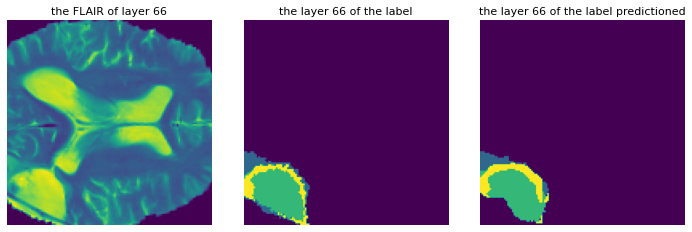

In [ ]:
labelPred = np.argmax(labelPred, axis=-1)

fig, axis = plt.subplots(ncols=3, figsize=(10,10))
img = image[:,:,66,2]
axis[0].imshow(img)
axis[0].set_title(f'the FLAIR of layer 66', fontsize=11)
axis[0].axis('off')

lbl = label[:,:,66]
axis[1].imshow(lbl)
axis[1].set_title(f'the layer 66 of the label', fontsize=11)
axis[1].axis('off')

lblP = labelPred[0,:,:,66]
axis[2].imshow(lblP)
axis[2].set_title(f'the layer 66 of the label predictioned', fontsize=11)
axis[2].axis('off')
plt.tight_layout()

[   0. 1000. 2000. 3000.]
(240, 240, 155)


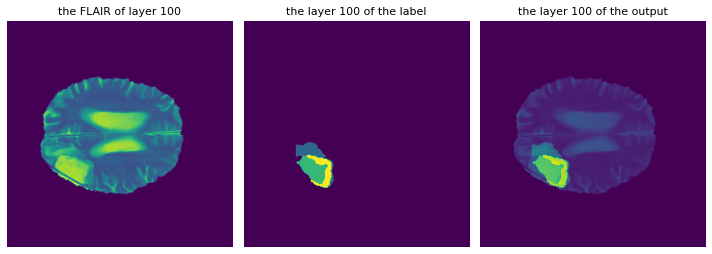

In [ ]:
fig, axis = plt.subplots(ncols=3, figsize=(10,10))
finalLbl = np.zeros((240,240,155))
x = volumSize[0]
y = volumSize[1]
z = volumSize[2]

axis[0].imshow(fullSizeImg[:,:,100,3])
axis[0].set_title(f'the FLAIR of layer 100', fontsize=11)
axis[0].axis('off')

finalLbl[55:55+x, 55:55+y, 20:20+z] += labelPred[0,:,:,:]

output = np.zeros_like(finalLbl)
output += (finalLbl*1000)
print(np.unique(output))
print(output.shape)
output += fullSizeImg[:,:,:,3]

axis[1].imshow(finalLbl[:,:,100])
axis[1].set_title(f'the layer 100 of the label', fontsize=11)
axis[1].axis('off')
plt.tight_layout()

axis[2].imshow(output[:,:,100])
axis[2].set_title(f'the layer 100 of the output', fontsize=11)
axis[2].axis('off')
plt.tight_layout()

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/logs.csv')

In [ ]:
df

,Unnamed: 0,epoch,diceCoef,loss,softDiceCoef,val_diceCoef,val_loss,val_softDiceCoef
0,0,0,0.563177,0.476751,0.240802,0.469367,0.517762,0.211479
1,1,1,0.682840,0.104787,0.337507,0.660660,0.084862,0.362670
2,2,2,0.734307,0.050971,0.398453,0.526475,0.146796,0.331935
3,3,3,0.755250,0.035922,0.426959,0.712343,0.035629,0.399920
4,4,4,0.762745,0.029191,0.442179,0.707268,0.034543,0.410600
5,5,5,0.762841,0.026207,0.445941,0.700147,0.030378,0.399220
6,6,6,0.773359,0.023503,0.458306,0.710211,0.029040,0.412359
7,7,7,0.783073,0.021481,0.467014,0.735066,0.024866,0.436872
8,8,8,0.787813,0.020085,0.472315,0.732216,0.024693,0.432835
9,9,9,0.792742,0.019039,0.477369,0.759094,0.021593,0.460585


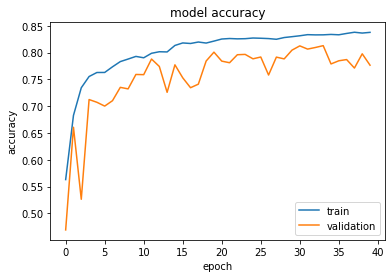

In [ ]:
plt.plot(df['diceCoef'])
plt.plot(df['val_diceCoef'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

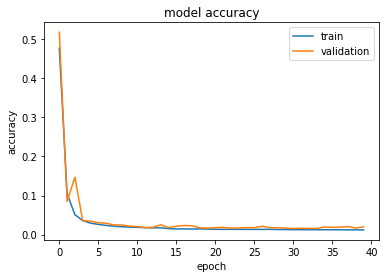

In [ ]:
plt.plot(df['loss'])
plt.plot(df['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()